<h1><center>GEICO Data Challenge-Yiyang Zhang</center></h1>

## Excecutive Summary

>My analysis has five main parts:
> <li><b>Business Understanding</b></li>
> <li><b>Data Understanding and Quality Check</b></li>
> <li><b>Data Munging</b></li>
> <li><b>Machine Learning Modelling</b> </li>
> <li><b>What's Next- the future improvement</b></li>
</ul>

>In the <b>Business Understanding</b> part, we analyze our primary goal and identify the question. 

>In the <b>Data Understanding and Quality Check</b> part, we propose the four dimensions of data quality check and use those dimensions as our baseline of the data quality check. Then we inspect the data as a whole to skim through our dataset. Next, we focused on checking the data quality in terms of Uniqueness, Completeness, Validity, and Accuracy. Lastly, we come up with data quality insights.

>In the <b>Data Munging</b> part, we fix the data quality issues and engineered features according to domain knowledge and business understanding.

>In the <b>Machine Learning Modelling</b> part, we use several feature engineering techniques. The first technique is to find features with a high percentage of missing values(80% and up). The second technique uses correlation analysis to find the colinear features- with a threshold above 0.8. The third technique is to find the Features with zero standard deviation (contains the same value, only 'CHANNEL1_6M'). The fourth technique is to find Features with high ranking in Step Forward Selection. Then we build the XGBoost algorithm for baseline and tune the hyperparameters using Grid Search. Considering it's an imbalanced dataset, after we get the hyperparameters of XGBoost, we use Synthetic Minority Oversampling Technique(SMOTE) in our XGBoost model to oversample the examples in the minority class to get better performance. The SMOTE-XGBoost model is our final algorithm and gets an AUC-ROC score of 85% in 10-fold cross-validation. Then we calculate some statistics and visualize the data. 

>My analysis successfully prepares the data for modeling and creates an excellent SMOTE-XGBoost model with a good performance in terms of the AUC score. We can use our model to predict the likelihood that each policyholder will make a service payment call and address the business problem.


>In the <b>What's Next- the future improvement</b> part, we reflect on what's the potential improvement for our analysis.

## Business Understanding

>In this project, we want to predict the likelihood that each policyholder will make a service payment call.We identify it as a classification question. To be more specific, this should be a binary classification question with an imbalanced target variable. 

>We need to find an algorithm that fits the imbalanced data well and has good performance in terms of the AUC score. We should compare different models to pick the one with the highest AUC score. In this way, the likelihood predicted by our model has the business insights we need.

## Data Understanding and Quality Check

###  The Four Dimensions of Data Quality Check

>Checklist of data quality:
> <li><b>Uniqueness</b>: Nothing will be recorded more than once base on how data is identified </li>
> <li><b>Completeness</b>: A measure of null values. </li>
> <li><b>Validity</b>: Data is valid if it conforms to the syntax of its definition such as format, type, and range </li>
> <li><b>Accuracy</b>: The degree to which data correctly describes the real world. </li>

</ul>

>We will evaluate the data quality in the six dimensions as shown. Before evaluating our data, we need to understand our data by exploring the data in Python land.

### Import Libraries and Load Datasets

In [1]:
import pandas as pd
from pandas import read_csv
import plotly.offline as py
import plotly.express as px
import folium
import numpy as np
from numpy import mean
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split   
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns
import itertools
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Our dataset is named as "data" initially
data=pd.read_csv("D:\\DS_MiniProject_ANON.csv")





### Inspect Data in General

```Python

#Print the shape of dataset
print(data.shape)
#The dataset has 130086 observations and 29 columns
```

> Since there are a bunch of columns in the dataset, we need to change the way we show the output in advance <br> so that we can see the full landscape of our data.

```Python
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
```

>Then let's skim through our dataset. This initial exploratory analysis is a crucial first step of data cleaning.

In [168]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)

```Python
# Print the head of dataset
print(data.head(2))

      
# Print the type of each column 
data.dtypes


# Print the missing values

print(data.info())
```



In [2]:
(data.Call_Flag==0).sum()/(data.Call_Flag==1).sum()
#The target variable has a severe imbalance problem. The majority is 26 times of the minority in the target variable.
#It might cause poor performance of our data.

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


26.306045340050378

>There are some data quality issues here.

> <li>Variables like 'CHANNEL1_6M','CHANNEL2_6M','CHANNEL3_6M','CHANNEL4_6M' ,'CHANNEL5_6M', should be the integer format, which may violate the <b>validity</b> of the quality </li>
> <li>There are some missing values in the some variables in the dataset, which may violate the <b>completeness</b> of the quality check </li>
> <li>The target variable has a severe imbalance problem, which might cause poor performance of our data.</li>

>We will check data quality according to the dimensions of data quality.

### Data Quality Check: Uniqueness

> To check the data quality in terms of uniqueness, we need to check whether there are any duplicate observations in each dataset. We use  <b><i>.duplicated().sum()</i> </b>method to check the uniqueness of our dataset.

```Python
print(data.duplicated().sum())



```
>There are 278 observations of duplicate data in the dataset.

### Data Quality Check: Completeness

> To check the data quality in terms of completeness, we need to check whether there are any missing values in each dataset. We use <b> <i>.isnull().sum()</i> </b> method to check the completeness of our dataset.

```Python

#check the number of missing value in each column of the dataset
data.isnull().sum()


```
> There are some missing values for the following variables: 'CHANNEL1_6M', 'CHANNEL2_6M','CHANNEL3_6M','CHANNEL4_6M' ,'CHANNEL5_6M', METHOD1_6M','RECENT_PAYMENT', 'PAYMENTS_6M'. Each variable has 809 rows of missing data, which is very suspecious. We need to check it out whether those 809 missing values is a coincidence or not.

>To figure out the suspicious 809 missing values in the 8 above variables, first, I need to reset index of the dataset so that we have a new column "index" which represents the unique ID for each customer. Second,I am trying to figure out whether they come from the same 809 customers.


In [3]:
resetdata=data.reset_index() # reset index

#check whether they come from the same 809 customers
print(sum(list(resetdata[resetdata['CHANNEL1_6M'].isnull()].index==resetdata[resetdata['CHANNEL2_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['CHANNEL2_6M'].isnull()].index==resetdata[resetdata['CHANNEL3_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['CHANNEL3_6M'].isnull()].index==resetdata[resetdata['CHANNEL4_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['CHANNEL4_6M'].isnull()].index==resetdata[resetdata['CHANNEL5_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['CHANNEL5_6M'].isnull()].index==resetdata[resetdata['CHANNEL4_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['METHOD1_6M'].isnull()].index==resetdata[resetdata['CHANNEL1_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['RECENT_PAYMENT'].isnull()].index==resetdata[resetdata['CHANNEL1_6M'].isnull()].index)))
print(sum(list(resetdata[resetdata['PAYMENTS_6M'].isnull()].index==resetdata[resetdata['CHANNEL1_6M'].isnull()].index)))

809
809
809
809
809
809
809
809


>Surprisingly,it turns out that the missing values in the above 8 variables come from 809 customers. Then who are they?
>We can find the unique ID of them

In [4]:
data[data['CHANNEL1_6M'].isnull()].index
#These IDs showing which customers have the missing data problem

Int64Index([   365,    869,   1051,   1413,   1468,   1547,   1804,   2143,
              2273,   2289,
            ...
            129366, 129400, 129427, 129541, 129548, 129577, 129688, 129767,
            129980, 130055],
           dtype='int64', length=809)

### Data Quality Check: Validity

```Python
# To check validity, we can use the method value_counts() to see if there are any abnormal or extreme values in each variable. 
print(data['CHANNEL1_6M'].value_counts(dropna=False))
print(data['CHANNEL2_6M'].value_counts(dropna=False))
print(data['CHANNEL3_6M'].value_counts(dropna=False))
print(data['CHANNEL4_6M'].value_counts(dropna=False))
print(data['CHANNEL5_6M'].value_counts(dropna=False))
print(data['METHOD1_6M'].value_counts(dropna=False))
print(data['RECENT_PAYMENT'].value_counts(dropna=False))
print(data['PAYMENTS_6M'].value_counts(dropna=False))
print(data['CustomerSegment'].value_counts(dropna=False))
print(data['EVENT1_30_FLAG'].value_counts(dropna=False)) 
print(data.dtypes)
```

>In those columns, some issues are violating the <b>validity</b> principle. 


> <li>The variable 'EVENT1_30_FLAG' has the same values across 129808 observations, which has zero standard deviation and doesn't help our models.  </li>
> <li>In the 'CustomerSegment' Variable, there are values recorded as "None".   </li>
> <li>Some variables should be in integer format instead of float format according to the definition.   </li>


### Data Quality Check: Accuracy

> We will use our common sense or domain knowledge to check whether the data is accurate. Based on our business understanding, the tenure should be less than the age for a policyholder. Also, the number of payments made through the same channel in last 6 months should be larger or equal to the number of payments made through the same channel in last 3 months. The Number of total payments in last 6 months should be larger or equal to the Number of total payments in last 6 months.

In [5]:
print(sum(data.PAYMENTS_6M<data.PAYMENTS_3M))
print(sum(data.Age<data.Tenure))
print(sum(data.CHANNEL1_6M<data.CHANNEL1_3M))
print(sum(data.CHANNEL2_6M<data.CHANNEL2_3M))
print(sum(data.CHANNEL2_6M<data.CHANNEL2_3M))
print(sum(data.CHANNEL2_6M<data.CHANNEL2_3M))
print(sum(data.CHANNEL2_6M<data.CHANNEL2_3M))

0
10
0
0
0
0
0


>There are 10 observations where the tenure is longer than the age of the policyholder, which is not acurrate. We should delete these observations. Other variables look perfect.

### Data quality insights and conclusion

>So far, we have figured out the landscape of the datasets. The dataset contains data on customers who have had a bill due in the next 5 days and whether they made a service payment call. 


>Insight 1: The dataset violates the <b>uniqueness</b> principle. There are 278 observations of duplicate data in the dataset. We should delete them.

>Insight 2: The dataset violates the <b>completeness </b> principle. There are 809 suspicious NaN values, which represent missing data. Meanwhile, In the 'CustomerSegment' variable, some abnormal values are recorded as"None," meaning the missing values.


>Insight 3: The 'EVENT1_30_FLAG' column in the dataset has the same values across all customers, which violates the <b>validity</b> principle. We should delete this variable.

>Insight 4: Some variables should be in integer format instead of float format according to the definition, which violates the principle of <b>validity</b>. We should convert them into integer format.

>Insight 5: The dataset violates the <b>accuracy</b> principle.There are 10 observations where the tenure is longer than the age of the policyholder, which is not acurrate. We should delete these observations. 

>Insight 6: The target variable has a severe imbalance problem. The majority is 26 times of the minority in the target variable. It might cause poor performance of our data.

## Data Munging

### Improve Data Quality 

>After figuring out the data quality issues, in the next step we want to improve data quality. We would firstly delete the duplicated values in the dataset because each row of data should represent a unique customer. 

In [26]:
data=data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
print(data.shape)

(129808, 29)


>After delete the duplicated observations, now the dataset has 129808 observations and 29 columns. Then we only keep those rows where the 'Tenure" variable is smaller than the 'Age' variable and delete the variable 'EVENT1_30_FLAG' since it has 0 of standard deviation.

In [27]:
data=data[data.Tenure<=data.Age] #keep those rows where the 'Tenure" variable is smaller than the 'Age' variable.
data = data.drop( ['EVENT1_30_FLAG'] ,axis="columns")#delete the variable 'EVENT1_30_FLAG'
print(data.shape)
#We now have 129898 rows and 28 columns.

(129798, 28)


### Imputing Missing Values with Business Understanding

>Then we are gonna interpolate the missing values for the following variables: CHANNEL1_6M, CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M , CHANNEL5_6M, METHOD1_6M, RECENT_PAYMENT, PAYMENTS_6M.

>From business understanding, we need to make a few assumptions before we interpolate missing values.
> <li>If the years of tenure of the company for the customer is less than 6 months, we would assume they have the same number of payments made through the same Channel between the last 6 months and last 3 months </li>
> <li>If the company's years of tenure for the customer are longer than 6 months, then we suppose the customer's payment behavior shouldn't change dramatically. </li>

>According to our first assumption, we would interpolate the missing values in the number of payments made through the Channel in the last 6 months with values in the variable representing the number of payments made through the Channel in the previous 3 months

In [31]:
#For those rows where the tenure is less than 6 months,
#assume they have the same number of payments made through the same Channel between last 6 months and last 3 months
data1=data[data['CHANNEL1_6M'].isnull()]
missingvalue1=data1.loc[data1.Tenure<0.5]
missingvalue1['CHANNEL1_6M']=missingvalue1['CHANNEL1_3M']
missingvalue1['CHANNEL2_6M']=missingvalue1['CHANNEL2_3M']
missingvalue1['CHANNEL3_6M']=missingvalue1['CHANNEL3_3M']
missingvalue1['CHANNEL4_6M']=missingvalue1['CHANNEL4_3M']
missingvalue1['CHANNEL5_6M']=missingvalue1['CHANNEL5_3M']
missingvalue1['METHOD1_6M']=missingvalue1['METHOD1_3M']
missingvalue1['PAYMENTS_6M']=missingvalue1['PAYMENTS_3M']
#According to our second assumption, the number of payments made through the Channel in the last 6 months 
#should be 2 times of the number of payments made through the Channel in the last 3 months
missingvalue2=data1.loc[data1.Tenure>=0.5]
missingvalue2['CHANNEL1_6M']=missingvalue2['CHANNEL1_3M']*2
missingvalue2['CHANNEL2_6M']=missingvalue2['CHANNEL2_3M']*2
missingvalue2['CHANNEL3_6M']=missingvalue2['CHANNEL3_3M']*2
missingvalue2['CHANNEL4_6M']=missingvalue2['CHANNEL4_3M']*2
missingvalue2['CHANNEL5_6M']=missingvalue2['CHANNEL5_3M']*2
missingvalue2['METHOD1_6M']=missingvalue2['METHOD1_3M']*2
missingvalue2['PAYMENTS_6M']=missingvalue2['PAYMENTS_3M']*2
missingvalue=pd.concat([missingvalue1,missingvalue2])



C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [32]:
data2=data[data['CHANNEL1_6M'].notnull()]
finaldata=pd.concat([missingvalue,data2])
finaldata=finaldata.reset_index()



### Imputing missing values with K Nearest Neighbor

>Next step is to deal with two tough variables: RECENT_PAYMENT and CustomerSegment. We are using k nearest neighbor to interpolate the missing values here. We suppose customers with similar features will have similar result in these two variables. KNN will do the classification for such scenarioes well. Firstly, convert the "None" value in CustomerSegment to missing values.Noted that we also need to create dummy variables for categorical variable because KNN don't consider text data. To better use KNN, we use min-max scale.

>After imputing the missing values, we will fix the data type issues.

In [34]:
#finaldata[finaldata.CustomerSegment=="NONE"].CustomerSegment=np.nan
finaldata.CustomerSegment=np.where(finaldata.CustomerSegment=="NONE", np.nan, finaldata.CustomerSegment)
#finaldata.isnull().sum()
finaldata.CustomerSegment

0           2
1           1
2           2
3           2
4           1
         ... 
129793    NaN
129794    NaN
129795    NaN
129796    NaN
129797      3
Name: CustomerSegment, Length: 129798, dtype: object

In [35]:

cat_variables = finaldata[['RTD_ST_CD', 'CustomerSegment','MART_STATUS','GENDER']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)

finaldata = finaldata.drop(['index','DATE_FOR','RTD_ST_CD', 'CustomerSegment','MART_STATUS','GENDER'], axis=1)#delete DATE_FOR because its meaningless
df = pd.concat([finaldata, cat_dummies], axis=1)
df.head()

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head()
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)



>Then we are going to fix wrong data formats. 

In [47]:
finaldata=df
finaldata['CHANNEL1_6M']=finaldata['CHANNEL1_6M'].astype("int")
finaldata['CHANNEL2_6M']=finaldata['CHANNEL2_6M'].astype("int")
finaldata['CHANNEL3_6M']=finaldata['CHANNEL3_6M'].astype("int")
finaldata['CHANNEL4_6M']=finaldata['CHANNEL4_6M'].astype("int")
finaldata['CHANNEL5_6M']=finaldata['CHANNEL5_6M'].astype("int")
finaldata['METHOD1_6M']=finaldata['METHOD1_6M'].astype("int")
finaldata['RECENT_PAYMENT']=finaldata['RECENT_PAYMENT'].astype("int")
finaldata['PAYMENTS_6M']=finaldata['PAYMENTS_6M'].astype("int")
finaldata['Call_Flag']=finaldata['Call_Flag'].astype("int")
finaldata['POLICYPURCHASECHANNEL']=finaldata['POLICYPURCHASECHANNEL'].astype("int")
finaldata['NOT_DI_6M']=finaldata['NOT_DI_6M'].astype("int")
finaldata['NOT_DI_3M']=finaldata['NOT_DI_3M'].astype("int")
finaldata['GENDER_M']=finaldata['GENDER_M'].astype("int")
finaldata['MART_STATUS_MS_S4']=finaldata['MART_STATUS_MS_S4'].astype("int")
finaldata['MART_STATUS_MS_S3']=finaldata['MART_STATUS_MS_S3'].astype("int")
finaldata['MART_STATUS_MS_S2']=finaldata['MART_STATUS_MS_S2'].astype("int")
finaldata['MART_STATUS_MS_S1']=finaldata['MART_STATUS_MS_S1'].astype("int")
finaldata['CustomerSegment_2']=finaldata['CustomerSegment_2'].astype("int")
finaldata['CustomerSegment_3']=finaldata['CustomerSegment_3'].astype("int")
#a=['RTD_ST_CD_ST_S1','RTD_ST_CD_ST_S10','RTD_ST_CD_ST_S11','RTD_ST_CD_ST_S12','RTD_ST_CD_ST_S13','RTD_ST_CD_ST_S14','RTD_ST_CD_ST_S15','RTD_ST_CD_ST_S16','RTD_ST_CD_ST_S17','RTD_ST_CD_ST_S18','RTD_ST_CD_ST_S19','RTD_ST_CD_ST_S2','RTD_ST_CD_ST_S20','RTD_ST_CD_ST_S21','RTD_ST_CD_ST_S22','RTD_ST_CD_ST_S23','RTD_ST_CD_ST_S24','RTD_ST_CD_ST_S25','RTD_ST_CD_ST_S26','RTD_ST_CD_ST_S27','RTD_ST_CD_ST_S28','RTD_ST_CD_ST_S29','RTD_ST_CD_ST_S3','RTD_ST_CD_ST_S30','RTD_ST_CD_ST_S31','RTD_ST_CD_ST_S32','RTD_ST_CD_ST_S33','RTD_ST_CD_ST_S34','RTD_ST_CD_ST_S35','RTD_ST_CD_ST_S36','RTD_ST_CD_ST_S37','RTD_ST_CD_ST_S38','RTD_ST_CD_ST_S39','RTD_ST_CD_ST_S4','RTD_ST_CD_ST_S40','RTD_ST_CD_ST_S41','RTD_ST_CD_ST_S42','RTD_ST_CD_ST_S43','RTD_ST_CD_ST_S44','RTD_ST_CD_ST_S45','RTD_ST_CD_ST_S46','RTD_ST_CD_ST_S47','RTD_ST_CD_ST_S48','RTD_ST_CD_ST_S49','RTD_ST_CD_ST_S5','RTD_ST_CD_ST_S50','RTD_ST_CD_ST_S6','RTD_ST_CD_ST_S7','RTD_ST_CD_ST_S8','RTD_ST_CD_ST_S9']   
#finaldata[a]=finaldata[a].astype("int")

In [48]:
#Take a look at our data
df.isnull().sum()

Tenure               0
Age                  0
CHANNEL1_6M          0
CHANNEL2_6M          0
CHANNEL3_6M          0
                    ..
MART_STATUS_MS_S1    0
MART_STATUS_MS_S2    0
MART_STATUS_MS_S3    0
MART_STATUS_MS_S4    0
GENDER_M             0
Length: 80, dtype: int64

In [14]:
df.dtypes

Tenure               float64
Age                  float64
CHANNEL1_6M            int32
CHANNEL2_6M            int32
CHANNEL3_6M            int32
                      ...   
MART_STATUS_MS_S1      int32
MART_STATUS_MS_S2      int32
MART_STATUS_MS_S3      int32
MART_STATUS_MS_S4      int32
GENDER_M               int32
Length: 80, dtype: object

>The missing values are all imputated appropriately and the type for each variable looks good! Let's move to engineer our features.

### Feature Engineering

>We engineered features based on my domain knowledge or manual expertise:

In [49]:
#feature engineering
finaldata['tenure_age_ratio']=finaldata.Tenure/finaldata.Age
finaldata['other_method_3M']=finaldata.PAYMENTS_3M-finaldata.METHOD1_3M #number of payments of other methods in the last 3M except method 1
finaldata['other_method_6M']=finaldata.PAYMENTS_6M-finaldata.METHOD1_6M#number of payments of other methods in the last 6M except method 1
finaldata['method1_minus_channel_3M']=finaldata.METHOD1_3M-finaldata.CHANNEL1_3M-finaldata.CHANNEL2_3M-finaldata.CHANNEL3_3M-finaldata.CHANNEL4_3M-finaldata.CHANNEL5_3M
finaldata['method1_minus_channel_6M']=finaldata.METHOD1_6M-finaldata.CHANNEL1_6M-finaldata.CHANNEL2_6M-finaldata.CHANNEL3_6M-finaldata.CHANNEL4_6M-finaldata.CHANNEL5_6M
finaldata['payments_minus_channel_3M']=finaldata.PAYMENTS_3M-finaldata.CHANNEL1_3M-finaldata.CHANNEL2_3M-finaldata.CHANNEL3_3M-finaldata.CHANNEL4_3M-finaldata.CHANNEL5_3M
finaldata['payments_minus_channel_6M']=finaldata.PAYMENTS_6M-finaldata.CHANNEL1_6M-finaldata.CHANNEL2_6M-finaldata.CHANNEL3_6M-finaldata.CHANNEL4_6M-finaldata.CHANNEL5_6M


In [60]:
finaldata

,Tenure,Age,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,RECENT_PAYMENT,PAYMENTS_6M,...,MART_STATUS_MS_S3,MART_STATUS_MS_S4,GENDER_M,tenure_age_ratio,other_method_3M,other_method_6M,method1_minus_channel_3M,method1_minus_channel_6M,payments_minus_channel_3M,payments_minus_channel_6M
0,0.006469,0.507337,0,0,0,0,0,0,0,0,...,1,0,1,0.012751,0.000000,0,0.0,0,0.000000,0
1,0.006382,0.409791,0,0,0,0,0,0,0,0,...,0,0,1,0.015575,0.000000,0,0.0,0,0.000000,0
2,0.006252,0.516213,0,0,0,0,0,0,0,0,...,1,0,1,0.012112,0.000000,0,0.0,0,0.000000,0
3,0.005080,0.163393,0,0,0,0,0,0,0,0,...,0,0,1,0.031090,0.000000,0,0.0,0,0.000000,0
4,0.004950,0.512272,0,0,0,0,0,0,0,0,...,0,0,1,0.009662,0.000000,0,0.0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129793,0.001563,0.357723,0,0,0,0,0,0,0,0,...,0,0,1,0.004369,0.027778,0,0.0,0,0.027778,0
129794,0.001346,0.240568,0,0,0,0,0,0,0,0,...,0,0,1,0.005595,0.055556,0,0.0,0,0.055556,0
129795,0.001563,0.486536,0,0,0,0,0,0,1,0,...,1,0,1,0.003213,0.027778,0,0.0,0,0.027778,0
129796,0.000868,0.086715,0,0,0,0,0,0,1,0,...,0,0,1,0.010014,0.027778,0,0.0,0,0.027778,0


In [55]:
df['method1_minus_channel_6M']
#finaldata.METHOD1_6M

0         0
1         0
2         0
3         0
4         0
         ..
129793    0
129794    0
129795    0
129796    0
129797    0
Name: method1_minus_channel_6M, Length: 129798, dtype: int32

## Machine Learning Modelling

### Feature Selection

>Feature selection was important because we had many columns and preferred to keep our models efficient. I used every trick we knew to select our features:
> <li>Delete features with tiny standard deviation (contains the same value)</li>
> <li>Delete features with collinear (highly correlated) features - with a threshold above 0.8  </li>
> <li>Delete features with a high percentage of missing values (90% and up) </li>
> <li>Use forward feature selection (using single or groups of features) </li>



>First, we will delete features with tiny standard deviation smaller than 0.03

In [51]:
cols=finaldata.columns
std1=[]
name=[]
for col in cols:
    std1.append(np.std(finaldata[col]))
    name.append(col)
checkdata=pd.DataFrame(data= {'col1': std1, 'col2': name})
checkdata[checkdata.col1<0.003] #vairiables to drop
#checkdata

#finaldata=finaldata.drop(list(checkdata[checkdata.col1<0.03].col2),axis=1)

,col1,col2
2,0.006206,CHANNEL1_6M
3,0.002776,CHANNEL2_6M
4,0.002776,CHANNEL3_6M
5,0.002776,CHANNEL4_6M
6,0.002776,CHANNEL5_6M
7,0.002776,METHOD1_6M
9,0.002776,PAYMENTS_6M
11,0.027652,CHANNEL2_3M
63,0.027327,RTD_ST_CD_ST_S46
66,0.026758,RTD_ST_CD_ST_S49


>In the second step of feature engineering, we will conduct correlation analysis and delete features with dollinear (highly correlated) features with threshold above 0.8

```Python
corrMatrix = finaldata.corr()
corrdata=pd.DataFrame(corrMatrix)
corrdata[(corrdata>0.8)&(corrdata<1)]
```
>In our correlation matrix, we find that:

> <li>'NOT_DI_3M' and 'CHANNEL1_3M' has a correlation of 0.826782</li>
> <li>'NOT_DI_3M' and 'NOT_DI_6M' has a correlation of 0.823161265</li>
> <li>'other_method_3M' and 'other_method_6M' has a correlation of 0.936453863</li>
> <li>'method1_minus_channel_6M' and 'method1_minus_channel_3M' has a correlation of 0.961364383</li>
> <li>'payments_minus_channel_6M' and 'payments_minus_channel_3M' has a correlation of 0.947199087</li>
> <li>'tenure_age_ratio' and 'tenure' has a high correlation</li>

>We will delete the following features:
'tenure_age_ratio','other_method_3M','method1_minus_channel_3M','payments_minus_channel_3M','NOT_DI_3M'




In [17]:
finaldata=finaldata.drop(['tenure_age_ratio', 'other_method_3M','method1_minus_channel_3M','payments_minus_channel_3M','NOT_DI_3M'],axis=1)

>Great! Having filtered out some features and considering that we don't have features with high percentage of missing values, we can now use forward feature selection.Step forward feature selection starts with the evaluation of each individual feature, and selects that which results in the best performing selected algorithm model. Next, all possible combinations of the that selected feature and a subsequent feature are evaluated, and a second feature is selected, and so on, until the required predefined number of features is selected.

In [ ]:
#Step forward feature selection


# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=15,
           forward=True,
           floating=False,
           verbose=2,
           scoring='roc_auc',
           cv=3)

# Perform SFFS


X=finaldata.drop(['Call_Flag'],axis=1)
y=finaldata.loc[:,['Call_Flag']]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=123)
# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

In [109]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
featuredata=finaldata.iloc[:,feat_cols]
featuredata.columns

[4, 5, 6, 8, 9, 13, 14, 16, 21, 46, 61, 65, 81, 84, 85]


Index(['CHANNEL3_6M', 'CHANNEL4_6M', 'CHANNEL5_6M', 'RECENT_PAYMENT',
       'PAYMENTS_6M', 'CHANNEL4_3M', 'CHANNEL5_3M', 'PAYMENTS_3M',
       'POLICYPURCHASECHANNEL', 'RTD_ST_CD_ST_S30', 'RTD_ST_CD_ST_S44',
       'RTD_ST_CD_ST_S48', 'other_method_3M', 'method1_minus_channel_6M',
       'payments_minus_channel_3M'],
      dtype='object')

### XGBoost

>XGBoost is considered the crown jewel of the decision-tree-based ensemble ML algorithms. XGBoost improves upon Gradient Boosting Machines through systems optimization and algorithmic enhancements.

>We will use XGBoost for this classification problem because it's more efficient than other classification models. However, we need to notice that the target variable is severely imbalanced, which will result in poor performance of XGBoost. Hence, we will first tune the hyperparameters of the XGBoost algorithm. After we get the best hyperparameters, we will pipeline XGBoost with Synthetic Minority Oversampling Technique to fix the imbalanced issue.

>Firstly we will use Grid Search to tune the n_estimators and learning_rate hyperparameters in XGBoost. The learning rate is significant for XGBoost because if we can't set an appropriate learning rate, the loss function of XGBoost might not converge. The n_estimators represent the tree size. It will cause an overfit or underfit problem if we fail to tune them.

In [59]:

# load data
X=featuredata
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))



C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best: 0.822820 using {'learning_rate': 0.1, 'n_estimators': 200}
0.768749 (0.010421) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.768769 (0.010439) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.769586 (0.011089) with: {'learning_rate': 0.0001, 'n_estimators': 300}
0.769586 (0.011089) with: {'learning_rate': 0.0001, 'n_estimators': 400}
0.773617 (0.012273) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.779285 (0.010050) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.780424 (0.011101) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.782329 (0.009715) with: {'learning_rate': 0.001, 'n_estimators': 300}
0.782345 (0.009732) with: {'learning_rate': 0.001, 'n_estimators': 400}
0.782892 (0.009845) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.792683 (0.009806) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.798823 (0.011787) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.805876 (0.009222) with: {'learning_rate': 0.01, 'n_estimators': 30

>The best learning_rate is 0.1 and the best n_estimators is 200. We will tune other hyperparameters in the next step

In [64]:

# load data
X=featuredata
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier(objective='binary:logistic',n_estimators=100,learning_rate=0.1)

min_child_weight=[1, 5, 10]
gamma=[0.5, 1, 3]
subsample=[0.6,  1.0]
colsample_bytree=[0.6, 1.0]
max_depth=[3, 5,10]
scale_pos_weight=[10,26]

print(max_depth)
param_grid = dic
t(scale_pos_weight=scale_pos_weight,min_child_weight=min_child_weight,max_depth=max_depth, gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[3, 5, 10]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 72.6min finished


Best: 0.822997 using {'colsample_bytree': 0.6, 'gamma': 3, 'max_depth': 5, 'min_child_weight': 10, 'scale_pos_weight': 10, 'subsample': 1.0}
0.822066 (0.003825) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 10, 'subsample': 0.6}
0.821625 (0.003393) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 10, 'subsample': 1.0}
0.822312 (0.003716) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 26, 'subsample': 0.6}
0.821802 (0.003272) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 26, 'subsample': 1.0}
0.822064 (0.003779) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight': 10, 'subsample': 0.6}
0.821657 (0.003522) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight':

>The tuned parameters are:'colsample_bytree': 0.6;'gamma': 3; 'max_depth': 5; 'min_child_weight': 10;'scale_pos_weight': 10;'subsample': 1.0

### XGBoost Baseline

In [107]:
X=featuredata
#X=finaldata.drop(['Call_Flag'],axis=1)
y=finaldata.loc[:,['Call_Flag']]

#baseline
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=123)
model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=3,eval_metric='auc',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=-1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26, seed=123,
              silent=None, subsample=1, verbosity=1)

model.fit(X_train,y_train)
preds=model.predict(X_test)
acc = accuracy_score(y_test,preds)
print("Test set accuracy: {:.2f}".format(acc))
y_pred_prob = model.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

cv_auc = cross_val_score(model,X,y,cv=3,scoring="roc_auc")
# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(np.mean(cv_auc)))
#AUC scores computed using 5-fold cross-validation: 83%, accuracy 75%

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Test set accuracy: 0.75
AUC: 0.8263325830324032


C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



AUC scores computed using 5-fold cross-validation: 0.8293724232176146


Confusion matrix, without normalization
[[18704  6331]
 [  231   694]]


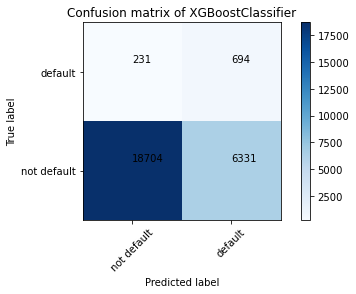

In [111]:

cnf_matrix=confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['not default','default'], normalize=False,
                      title='Confusion matrix of XGBoostClassifier')

plt.show()



### Synthetic Minority Oversampling Technique(SMOTE-XGboost)

>A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

>One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

>Synthetic Minority Oversampling Technique (SMOTE) is the perfect solution here.SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [143]:

# grid search k value for SMOTE oversampling for imbalanced classification

# define dataset
#featuredata=finaldata.loc[:,['CHANNEL3_3M','CHANNEL4_3M','CHANNEL5_3M','PAYMENTS_3M','method1_minus_channel_6M']]
X=finaldata.drop(['Call_Flag'],axis=1)
#X=featuredata
y=finaldata.loc[:,['Call_Flag']]
# values to evaluate

# define pipeline
k_values = [1]
for k in k_values:
    # define pipeline
    model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=3,eval_metric='auc',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=-1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26, seed=123,
              silent=None, subsample=1, verbosity=1)
    
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

    #0.822
    #0.854

> k=1, Mean ROC AUC: 0.847


In [151]:
print(scores)

[0.85983496 0.8401811  0.84560957 0.84626068 0.83435416 0.84438482
 0.84872243 0.85115143 0.83967817 0.85570259 0.83828418 0.84508347
 0.84193955 0.84543562 0.85128962 0.85117332 0.84888277 0.8512362
 0.84783852 0.84599836 0.85901599 0.8421373  0.83618958 0.83883103
 0.8478616  0.84643204 0.84581514 0.85388952 0.84878654 0.85182857]


>The SMOTE-XGBoost model performs well to address the business problem. For this imbalanced customer classification problem, the SMOTE-XGBoost performs better than the basic well-tuned XGBoost model in terms of the AUC score. It has an AUC score of 0.85, which is suitable for classification tasks. With this model, I can successfully predict the likelihood that each policyholder will make a service payment call with high accuracy(XGBoost) and a high AUC score(SMOTE-XGBoost). We adopt the SMOTE-XGBoost model for our tasks because it has a high AUC score, which is the most critical metric for classification problems.

### Data Visualization

>In data visualization part, we will plot confusion matrix, AUC-ROC curve and the feature importance ranking. It will give us an understanding of the black-box model.

Confusion matrix, without normalization
[[18926  6109]
 [  220   705]]


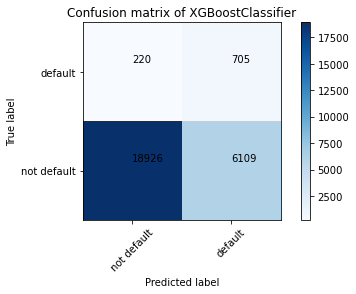

[0.69096214 0.6523424  0.08040375 ... 0.93185496 0.6633463  0.04075559]


<AxesSubplot:title={'center':'Features importance (XGBoost)'}, xlabel='F score', ylabel='Features'>

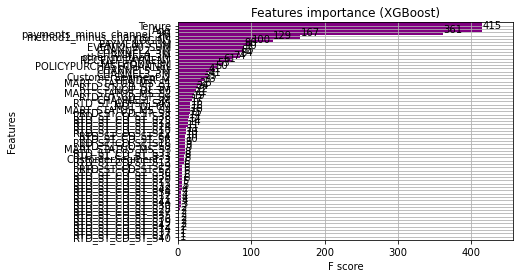

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap,origin='lower')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i+0.1, cm[i, j],
                               color= "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
X=featuredata
#X=finaldata.drop(['Call_Flag'],axis=1)
y=finaldata.loc[:,['Call_Flag']]

#baseline
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=123)
model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=3,eval_metric='auc',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=-1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26, seed=123,
              silent=None, subsample=1, verbosity=1)

model.fit(X_train,y_train)
preds=model.predict(X_test)
# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['not default','default'], normalize=False,
                      title='Confusion matrix of XGBoostClassifier')

plt.show()



y_pred_prob = model.predict_proba(X_test)[:,1]
print(y_pred_prob)

# Generate ROC curve values: 
fpr2, tpr2, thresholds = roc_curve(y_test,y_pred_prob )


xgb.plot_importance(model, height=3.8, title="Features importance (XGBoost)",  color="purple") 


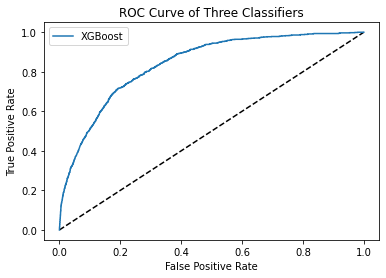

In [83]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr2, tpr2,label="XGBoost")

plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Classifiers')
plt.show()

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['CHANNEL4_3M', 'payments_minus_channel_3M', 'CHANNEL5_3M', 'PAYMENTS_3M', 'other_method_3M']


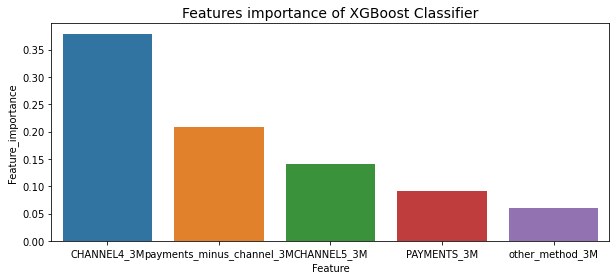

In [154]:
X=featuredata
#X=finaldata.drop(['Call_Flag'],axis=1)
y=finaldata.loc[:,['Call_Flag']]

#baseline
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=123)
model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=3,eval_metric='auc',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=-1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26, seed=123,
              silent=None, subsample=1, verbosity=1)

model.fit(X_train,y_train)
preds=model.predict(X_test)
impo=model.feature_importances_

tmp = pd.DataFrame({'Feature': X.columns, 'Feature_importance': impo})
tmp = tmp.sort_values(by='Feature_importance',ascending=False)
tmp=tmp.iloc[:5,:]
print(list(tmp.Feature))
plt.figure(figsize = (10,4))
plt.title('Features importance of XGBoost Classifier',fontsize=14)
s = sns.barplot('Feature','Feature_importance',data=tmp)

In [167]:


fig = px.bar(tmp.Feature, x=tmp.Feature, y=tmp.Feature_importance,
             hover_data=['Feature'], color='Feature',
                 labels={'Feature':'feature'}, height=400,title='Top 5 important features')
fig.show()
#This is interactive. You can hover your mouse to see the values

## What's Next 

>Due to time and software limits, we didn't tune all the hyperparameters in XGBoost. If we tune all the hyperparameters in a wide range, it will have better performance in terms of the AUC score.

>In the feature engineering part, we could use the methods based on automated feature engineering using SparkBeyond)(SB) for feature exploration & insights.

>In the feature selection part, we could try more feature selection techniques such as recursive feature elimination to compare and combine different feature selection techniques.